# NCICS ML Lesson 12: hyperparameter tuning methods

In order to run this notebook, you will need to install Google Chrome's [Open in Colab](https://chrome.google.com/webstore/detail/open-in-colab/) extension.

Welcome to our lesson on how to tune your machine learning models' hyperparameters!  This notebook demonstrate three different hyperparameter tuning techniques:
- Grid Search
- Random Search
- Bayesian Optimization

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/1920px-Iris_virginica.jpg title= "Iris virginica" alt= "Iris virginica" width="300" align="right">

Douglas' R notebook examples use a simulated data set. For a few different reasons, I decided to use the famous Iris data set in this notebook. It's a data set with measurements taken from three species of irises (yep, the flowering plants: the picture to the right is an excellent example of _Iris virginica_). The four features used in this data set are:
- sepal length
- sepal width
- petal length
- petal width

Here's the Wikipedia article on the famous [Iris Flower Data Set](https://en.wikipedia.org/wiki/Iris_flower_data_set).  Also, if you want to know more about embedding images in markdown within these notebooks, this [StackOverflow](https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o) post has several useful explanations.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix
from time import time

/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


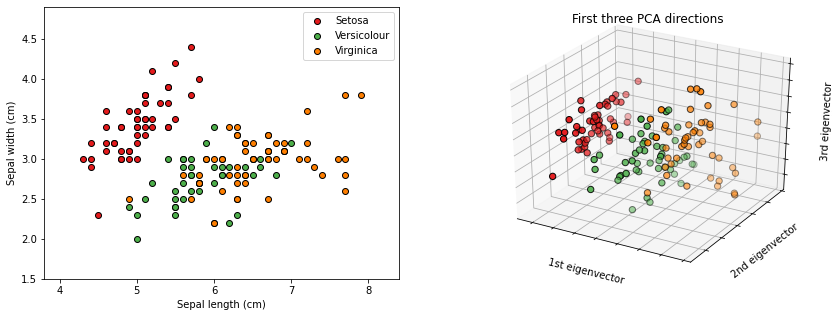

In [3]:
# Import the Iris data set.
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

# Plot the training points.
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 2, 1)
for label, idx in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    species_indices = np.argwhere(y == idx).ravel()
    ax.scatter(
        X[species_indices, 0], X[species_indices, 1],
        color=plt.cm.Set1.colors[idx*2],
        label=label,edgecolor='k'
    )

# Make the plot pretty.
ax.set_xlabel('Sepal length (cm)')
ax.set_ylabel('Sepal width (cm)')
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend()


# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions.
ax = fig.add_subplot(1, 2, 2, projection='3d')

X_reduced = PCA(n_components=3).fit_transform(iris.data)

for label, idx in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    species_indices = np.argwhere(y == idx).ravel()
    ax.scatter(
        X_reduced[species_indices, 0], X_reduced[species_indices, 1], X_reduced[species_indices, 2],
        color=plt.cm.Set1.colors[idx*2],
        edgecolor='k', s=40
    )

# Make the 3D plot pretty.
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

fig.show()

# Grid search

In [4]:
clf = SVC(kernel="rbf")

# Utility function to report best scores.
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# Specify parameters and distributions from which to sample the hyperparameters.
param_grid = {
    'C': np.power(10, np.arange(start=-5, stop=3, step=0.5, dtype=float)), 
    'gamma': np.power(10, np.arange(start=-4, stop=2, step=0.5, dtype=float)),
#     'kernel': ['rbf', 'poly', 'sigmoid']
}

# Run the grid search.
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 3.30 seconds for 192 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.827 (std: 0.085)
Parameters: {'C': 1e-05, 'gamma': 1.0}

Model with rank: 1
Mean validation score: 0.827 (std: 0.085)
Parameters: {'C': 3.1622776601683795e-05, 'gamma': 1.0}

Model with rank: 1
Mean validation score: 0.827 (std: 0.085)
Parameters: {'C': 0.0001, 'gamma': 1.0}

Model with rank: 1
Mean validation score: 0.827 (std: 0.085)
Parameters: {'C': 0.00031622776601683794, 'gamma': 1.0}

Model with rank: 1
Mean validation score: 0.827 (std: 0.085)
Parameters: {'C': 0.001, 'gamma': 1.0}

Model with rank: 1
Mean validation score: 0.827 (std: 0.085)
Parameters: {'C': 0.0031622776601683794, 'gamma': 1.0}

Model with rank: 1
Mean validation score: 0.827 (std: 0.085)
Parameters: {'C': 0.01, 'gamma': 1.0}

Model with rank: 1
Mean validation score: 0.827 (std: 0.085)
Parameters: {'C': 0.03162277660168379, 'gamma': 1.0}

Model with rank: 1
Mean validation score: 0.827 (std: 0.085

In [11]:
results = grid_search.cv_results_

mean_test_score = results['mean_test_score']
std_test_score = results['std_test_score']
params = results['params']

In [18]:
C 

(array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
        1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
        1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
        1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02]),)

In [19]:
# C = [params[idx]['C'] for idx in range(len(params))]
# gamma = [params[idx]['gamma'] for idx in range(len(params))]
C = np.power(10, np.arange(start=-5, stop=3, step=0.5, dtype=float))
gamma = np.power(10, np.arange(start=-4, stop=2, step=0.5, dtype=float))
score = [mean_test_score[idx] for idx in range(len(results))]

for array in [C, gamma, score]:
    print(len(array)) 

16
12
20


In [1]:
fig, ax = plt.subplots(1, 1)
ax.tricontourf(C, gamma, score, levels=12, cmap="RdBu_r")
fig.show()

# Random search

In [5]:
# Now run the randomized search.
n_iter_search = 100

param_dist = {
    'C': loguniform(1e-4, 1e2), 
    'gamma': loguniform(1e-3, 1e1),
}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 0.77 seconds for 100 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.840 (std: 0.065)
Parameters: {'C': 0.10944005286265468, 'gamma': 1.4757336507912886}

Model with rank: 2
Mean validation score: 0.833 (std: 0.060)
Parameters: {'C': 0.014212894883307453, 'gamma': 2.1750668667507984}

Model with rank: 3
Mean validation score: 0.827 (std: 0.053)
Parameters: {'C': 13.528453419827033, 'gamma': 0.300321219925498}

Model with rank: 3
Mean validation score: 0.827 (std: 0.065)
Parameters: {'C': 0.018375642163108077, 'gamma': 1.2169736746601778}

Model with rank: 3
Mean validation score: 0.827 (std: 0.053)
Parameters: {'C': 11.776132769315769, 'gamma': 0.31066211762091417}

Model with rank: 3
Mean validation score: 0.827 (std: 0.053)
Parameters: {'C': 2.6471833171565553, 'gamma': 0.39393100381286916}



# Bayesian optimization

In [1]:
def hyperopt_train_test(params):
    X_ = X[:]
    clf = SVC(**params, kernel="rbf")
    return cross_val_score(clf, X_, y).mean()

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

param_dist_hyperopt = {
    'C': hp.loguniform('SVC_C', 1e-4, 1e2), 
    'gamma': hp.loguniform('SVC_gamma', 1e-3, 1e1),
}

trials = Trials()

best = fmin(f, param_dist_hyperopt, algo=tpe.suggest, max_evals=100, trials=trials)